# Pneumonia Identification Project

# Business and Data Understanding


# Data preparation

In [1]:
from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np

In [2]:
# Linking directory path
train_data_dir = 'data/chest_xray/train'
val_data_dir = 'data/chest_xray/val'

In [312]:
# Getting train and validation data from directory
val_generator = ImageDataGenerator().flow_from_directory(val_data_dir,
                                                         target_size=(64, 64),
                                                         batch_size=232,
                                                         class_mode='categorical',
                                                         seed=42)

train_generator = ImageDataGenerator().flow_from_directory(train_data_dir,
                                                           target_size=(64, 64),
                                                           batch_size=2500,
                                                           class_mode='categorical',
                                                           seed=42)

Found 232 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [313]:
# Creating datasets, May take time to run.
train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)

In [315]:
# Reshaping data
train_img_unrow = train_images.reshape(2500, -1)
val_img_unrow = val_images.reshape(232, -1)

In [316]:
print(np.shape(train_img_unrow))
print(np.shape(val_img_unrow))

(2500, 12288)
(232, 12288)


In [317]:
# Normalizing data
train_img_final = train_img_unrow/255.0
val_img_final = val_img_unrow/255.0

# Modeling

In [11]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [12]:
# Function to quickly plot model results
def plot_results(model_results):
    """
    This function will take in the results of a model and plot the loss and accuracy of the model.

    Args:
    model_results (list): the results of the model in [] brackets.
    """
    for results in model_results:
        train_loss = results.history['loss']
        train_acc = results.history['accuracy']
        val_loss = results.history['val_loss']
        val_acc = results.history['val_accuracy']

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
        sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

        sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
        sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
        ax1.set_title('Loss')
        ax2.set_title('Accuracy')
        ax1.legend();

In [319]:
model_1 = Sequential()

In [320]:
model_1.add(layers.Input(shape=(12288,)))
model_1.add(Dense(50, activation='relu'))
model_1.add(Dense(25, activation='relu'))
model_1.add(Dense(10, activation='relu'))
model_1.add(Dense(2, activation='softmax'))

In [321]:
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [322]:
model_1_results = model_1.fit(train_img_final, train_labels,
                              epochs=10,
                              batch_size=125, 
                              validation_data=(val_img_final, val_labels))

Epoch 1/10
20/20 [==============================] - 0s 6ms/step - loss: 0.7098 - accuracy: 0.6956 - val_loss: 0.4705 - val_accuracy: 0.8448
Epoch 2/10
20/20 [==============================] - 0s 3ms/step - loss: 0.3188 - accuracy: 0.8744 - val_loss: 0.4679 - val_accuracy: 0.7716
Epoch 3/10
20/20 [==============================] - 0s 4ms/step - loss: 0.2550 - accuracy: 0.9036 - val_loss: 0.5772 - val_accuracy: 0.7155
Epoch 4/10
20/20 [==============================] - 0s 4ms/step - loss: 0.2329 - accuracy: 0.9052 - val_loss: 0.5057 - val_accuracy: 0.7629
Epoch 5/10
20/20 [==============================] - 0s 3ms/step - loss: 0.2029 - accuracy: 0.9172 - val_loss: 0.5377 - val_accuracy: 0.7500
Epoch 6/10
20/20 [==============================] - 0s 3ms/step - loss: 0.2052 - accuracy: 0.9200 - val_loss: 0.3684 - val_accuracy: 0.8276
Epoch 7/10
20/20 [==============================] - 0s 3ms/step - loss: 0.1584 - accuracy: 0.9420 - val_loss: 0.3134 - val_accuracy: 0.8664
Epoch 8/10
20/20 [==

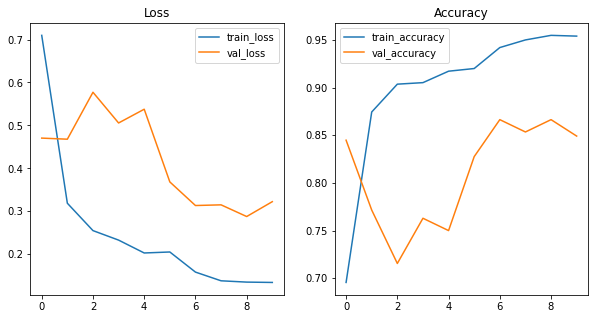

In [323]:
plot_results([model_1_results])

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=5e-6)

In [324]:
model_2 = Sequential()

In [325]:
model_2.add(layers.Input(shape=(12288,)))
model_2.add(Dense(50, activation='relu'))
model_2.add(Dense(25, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(10, activation='relu'))
model_2.add(Dropout(0.2))
model_2.add(Dense(2, activation='softmax'))

In [326]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [327]:
model_2_results = model_2.fit(train_img_final, train_labels,
                              epochs=50,
                              batch_size=300, 
                              validation_data=(val_img_final, val_labels))

Epoch 1/50
9/9 [==============================] - 0s 12ms/step - loss: 1.0310 - accuracy: 0.5268 - val_loss: 0.7012 - val_accuracy: 0.5000
Epoch 2/50
9/9 [==============================] - 0s 5ms/step - loss: 0.7117 - accuracy: 0.5604 - val_loss: 0.6564 - val_accuracy: 0.5733
Epoch 3/50
9/9 [==============================] - 0s 5ms/step - loss: 0.6190 - accuracy: 0.6452 - val_loss: 0.6534 - val_accuracy: 0.5000
Epoch 4/50
9/9 [==============================] - 0s 5ms/step - loss: 0.5828 - accuracy: 0.6780 - val_loss: 0.6529 - val_accuracy: 0.5000
Epoch 5/50
9/9 [==============================] - 0s 5ms/step - loss: 0.5373 - accuracy: 0.7040 - val_loss: 0.5664 - val_accuracy: 0.7112
Epoch 6/50
9/9 [==============================] - 0s 5ms/step - loss: 0.4827 - accuracy: 0.7388 - val_loss: 0.4982 - val_accuracy: 0.7716
Epoch 7/50
9/9 [==============================] - 0s 5ms/step - loss: 0.4282 - accuracy: 0.8000 - val_loss: 0.4875 - val_accuracy: 0.7457
Epoch 8/50
9/9 [=================

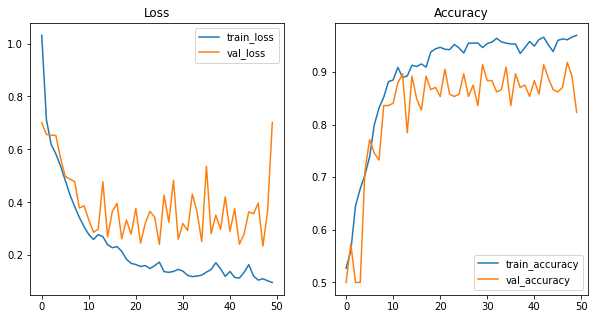

In [328]:
plot_results([model_2_results])

In [329]:
model_3 = Sequential()

In [330]:
model_3.add(layers.Input(shape=(12288,)))
model_3.add(Dense(50, activation='relu'))
model_3.add(Dense(50, activation='relu', kernel_regularizer=l2(l2=0.5)))
model_3.add(Dropout(0.5))
model_3.add(Dense(25, activation='relu'))
model_3.add(Dense(25, activation='relu', kernel_regularizer=l2(l2=0.25)))
model_3.add(Dropout(0.2))
model_3.add(Dense(10, activation='relu'))
model_3.add(Dense(2, activation='softmax'))

In [331]:
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [332]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [333]:
model_3_results = model_3.fit(train_img_final, train_labels,
                              epochs=40, 
                              batch_size=350,
                              validation_data=(val_img_final, val_labels),
                              callbacks=[early_stop])

Epoch 1/40
8/8 [==============================] - 0s 15ms/step - loss: 31.3075 - accuracy: 0.7388 - val_loss: 29.5309 - val_accuracy: 0.5000
Epoch 2/40
8/8 [==============================] - 0s 7ms/step - loss: 28.3732 - accuracy: 0.7352 - val_loss: 26.9090 - val_accuracy: 0.5000
Epoch 3/40
8/8 [==============================] - 0s 7ms/step - loss: 25.8321 - accuracy: 0.7408 - val_loss: 24.5117 - val_accuracy: 0.5000
Epoch 4/40
8/8 [==============================] - 0s 7ms/step - loss: 23.4831 - accuracy: 0.7460 - val_loss: 22.2870 - val_accuracy: 0.5000
Epoch 5/40
8/8 [==============================] - 0s 8ms/step - loss: 21.3194 - accuracy: 0.7436 - val_loss: 20.2486 - val_accuracy: 0.5000
Epoch 6/40
8/8 [==============================] - 0s 7ms/step - loss: 19.3468 - accuracy: 0.7444 - val_loss: 18.3968 - val_accuracy: 0.5000
Epoch 7/40
8/8 [==============================] - 0s 7ms/step - loss: 17.5405 - accuracy: 0.7440 - val_loss: 16.7210 - val_accuracy: 0.5000
Epoch 8/40
8/8 [===

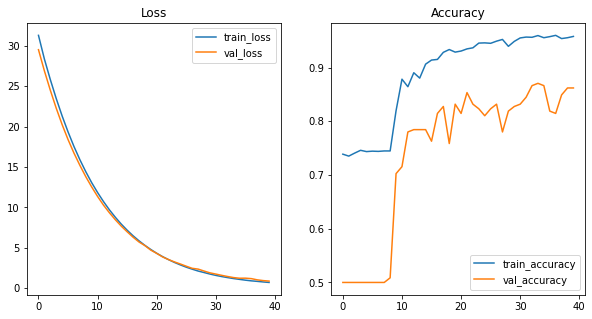

In [334]:
plot_results([model_3_results])

In [335]:
model_4 = Sequential()

In [336]:
model_4.add(layers.Input(shape=(12288,)))
model_4.add(Dense(75, activation='relu'))
model_4.add(Dense(50, activation='relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(50, activation='relu', kernel_regularizer=l2(l2=0.5)))
model_4.add(Dense(25, activation='relu'))
model_4.add(Dropout(0.25))
model_4.add(Dense(25, activation='relu', kernel_regularizer=l2(l2=0.25)))
model_4.add(Dense(10, activation='relu', kernel_regularizer=l2(l2=0.01)))
model_4.add(Dense(2, activation='softmax'))

In [337]:
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [338]:
model_4_results = model_4.fit(train_img_final, train_labels,
                              epochs=50,
                              batch_size=250,
                              validation_data=(val_img_final, val_labels),
                              callbacks=[early_stop])

Epoch 1/50
10/10 [==============================] - 0s 14ms/step - loss: 29.2380 - accuracy: 0.7436 - val_loss: 27.5093 - val_accuracy: 0.5000
Epoch 2/50
10/10 [==============================] - 0s 7ms/step - loss: 25.9675 - accuracy: 0.7408 - val_loss: 24.4204 - val_accuracy: 0.5000
Epoch 3/50
10/10 [==============================] - 0s 6ms/step - loss: 23.0040 - accuracy: 0.7444 - val_loss: 21.6428 - val_accuracy: 0.5000
Epoch 4/50
10/10 [==============================] - 0s 6ms/step - loss: 20.3354 - accuracy: 0.7436 - val_loss: 19.1329 - val_accuracy: 0.5000
Epoch 5/50
10/10 [==============================] - 0s 7ms/step - loss: 17.9542 - accuracy: 0.7448 - val_loss: 16.9327 - val_accuracy: 0.5000
Epoch 6/50
10/10 [==============================] - 0s 6ms/step - loss: 15.8435 - accuracy: 0.7452 - val_loss: 14.9455 - val_accuracy: 0.5000
Epoch 7/50
10/10 [==============================] - 0s 6ms/step - loss: 13.9654 - accuracy: 0.7504 - val_loss: 13.2964 - val_accuracy: 0.5000
Epoch

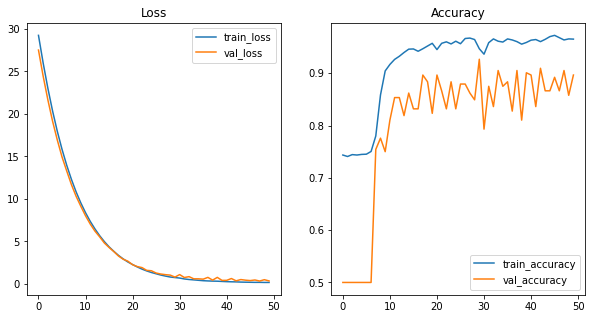

In [339]:
plot_results([model_4_results])

In [362]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=1e-5)

In [363]:
model_5 = models.Sequential()

In [364]:
model_5.add(layers.Conv2D(16, (5, 5), activation='relu', input_shape=(64, 64, 3)))
model_5.add(layers.BatchNormalization())
model_5.add(layers.MaxPooling2D())

model_5.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model_5.add(layers.BatchNormalization())
model_5.add(layers.Dropout(0.5))
model_5.add(layers.MaxPooling2D())

model_5.add(layers.Conv2D(64, (3, 3), activation='relu', padding='valid'))
#model_5.add(layers.BatchNormalization())
model_5.add(layers.MaxPooling2D())

model_5.add(layers.Conv2D(128, (3, 3), activation='relu', padding='valid'))
#model_5.add(layers.BatchNormalization())
model_5.add(layers.Dropout(0.1))
model_5.add(layers.MaxPooling2D())

model_5.add(layers.Flatten())
model_5.add(layers.Dense(2, activation='softmax'))

In [365]:
model_5.compile(Adam(learning_rate=0.00025), loss='categorical_crossentropy', metrics=['accuracy'])

In [366]:
model_5_results = model_5.fit(train_images, train_labels,
                              epochs=13,
                              batch_size=320,
                              validation_data=(val_images, val_labels),
                              callbacks=[early_stop, reduce_lr])

Epoch 1/13
8/8 [==============================] - 2s 279ms/step - loss: 0.6894 - accuracy: 0.7080 - val_loss: 1.6857 - val_accuracy: 0.5000
Epoch 2/13
8/8 [==============================] - 2s 269ms/step - loss: 0.3850 - accuracy: 0.8588 - val_loss: 0.5686 - val_accuracy: 0.6595
Epoch 3/13
8/8 [==============================] - 2s 273ms/step - loss: 0.2739 - accuracy: 0.8948 - val_loss: 0.5641 - val_accuracy: 0.7198
Epoch 4/13
8/8 [==============================] - 2s 272ms/step - loss: 0.2042 - accuracy: 0.9244 - val_loss: 0.4242 - val_accuracy: 0.8017
Epoch 5/13
8/8 [==============================] - 2s 273ms/step - loss: 0.1800 - accuracy: 0.9348 - val_loss: 0.2903 - val_accuracy: 0.8621
Epoch 6/13
8/8 [==============================] - 2s 267ms/step - loss: 0.1457 - accuracy: 0.9452 - val_loss: 0.2753 - val_accuracy: 0.8621
Epoch 7/13
8/8 [==============================] - 2s 271ms/step - loss: 0.1434 - accuracy: 0.9432 - val_loss: 0.2776 - val_accuracy: 0.8707
Epoch 8/13
8/8 [====

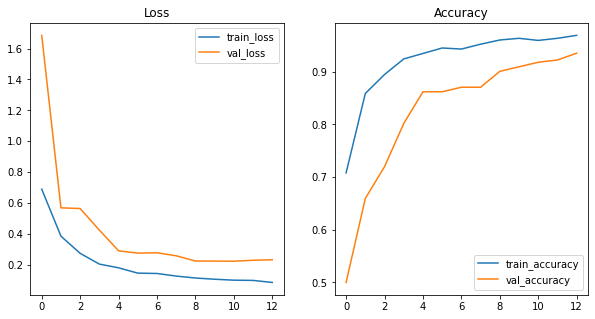

In [367]:
plot_results([model_5_results])

# Evaluation